### EDA + Data Cleaning + Feature Generation

In [3]:
import pandas as pd
import numpy as np 
from plotnine import *

import holidays

pd.set_option('display.max.columns', 500)

In [3]:
train = pd.read_csv("C:/Users/mathi/OneDrive/Python/52-Weeks-of-Python-and-R-2023/11 - Kaggle Competition Rob Mulla/Data/train_prepped.csv",
                    parse_dates=['date'])
test = pd.read_csv("C:/Users/mathi/OneDrive/Python/52-Weeks-of-Python-and-R-2023/11 - Kaggle Competition Rob Mulla/Data/test_prepped.csv",
                   parse_dates=['date'])

Let's look at the target variable:

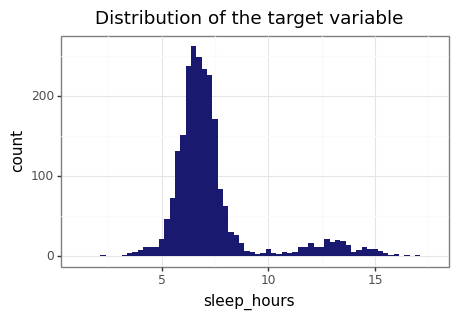

<ggplot: (144389931660)>

In [4]:
(
    ggplot(data=train,
           mapping=aes(x='sleep_hours')) +
    geom_histogram(fill='midnightblue', binwidth=0.25) +
    labs(title = 'Distribution of the target variable') +
    theme_bw() +
    theme(figure_size=[5, 3])
)


Those outliers look a little weird...

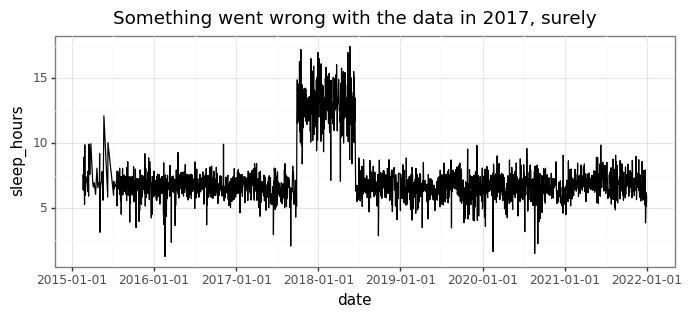

<ggplot: (144389932023)>

In [5]:
(
    ggplot(data=train,
           mapping=aes(x='date', y='sleep_hours', group=1)) +
    geom_line() +
    labs(title='Something went wrong with the data in 2017, surely') +
    theme_bw() +
    theme(figure_size=[8, 3])
)


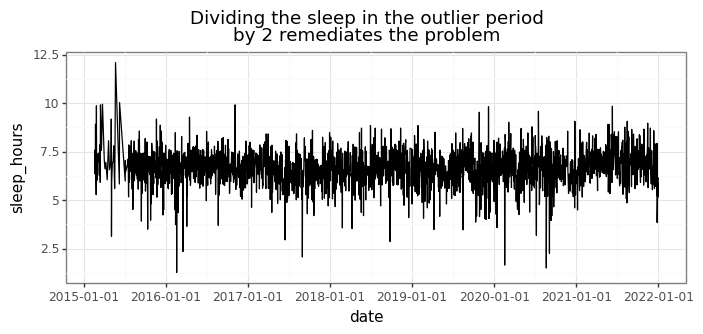

<ggplot: (144389964191)>

In [6]:
(
    ggplot(data=(train
                 .assign(sleep_hours=lambda x: np.select(
                     condlist=[np.logical_and(x['date'] > "2017-09-26",
                                              x['date'] < "2018-06-16")],
                     choicelist=[x['sleep_hours'] * 0.5],
                     default=x['sleep_hours']
                 ))
                 ),
           mapping=aes(x='date', y='sleep_hours', group=1)) +
    geom_line() +
    labs(title='Dividing the sleep in the outlier period\nby 2 remediates the problem') +
    theme_bw() +
    theme(figure_size=[8, 3])
)


Overwrite the outliers by the scaling with $\frac{1}{2}$:

In [7]:
train = (train
 .assign(sleep_hours=lambda x: np.select(
     condlist=[np.logical_and(x['date'] > "2017-09-26",
                              x['date'] < "2018-06-16")],
     choicelist=[x['sleep_hours'] * 0.5],
     default=x['sleep_hours']
 ))
 )

I can also extract more features from the date column:

- year,
- week,
- day in week etc...

Also, holiday times in the US!

In [8]:
def get_date_features(df):
    # get features from date column
    df = (df
          .assign(year=lambda x: x.date.dt.year,
                  month=lambda x: x.date.dt.month,
                  dom=lambda x: x.date.dt.day,
                  doy=lambda x: x.date.dt.day_of_year,
                  week=lambda x: x.date.dt.isocalendar().week,
                  dow=lambda x: x.date.dt.day_of_week,
                  quarter=lambda x: x.date.dt.quarter)
          )

    # get holidays
    holidays_US = (pd.DataFrame(holidays.CountryHoliday('US', years=[year for year in range(2015, 2023+1)]),
                                index=[0])
                   .melt()
                   .assign(variable=lambda x: pd.to_datetime(x.variable))
                   .sort_values('variable')
                   .reset_index(drop=True)
                   .rename(columns={'variable': 'date', 'value': 'holiday'})
                   )
    
    df = (df
     .merge(holidays_US, how='left', on='date')
     .assign(holiday=lambda x: x.holiday.fillna('No Holiday'),
             is_holiday=lambda x: np.select(condlist=[x.holiday == 'No Holiday'],
                                            choicelist=[0],
                                            default=1))
     )
    
    return df


In [9]:
train = get_date_features(train)
test = get_date_features(test)

Create lagged target variable (last 7 day):

In [10]:
def create_lags(df):
    for i in range(1, 7+1):
        column_name = 'target_lag_' + str(i)
        df[column_name] = df['sleep_hours'].shift(i)
    
    return df

In [11]:
train = create_lags(train)
test = create_lags(test)

Finally, write everything to csv:

In [15]:
train.to_csv("Data/train_prepped_final.csv", index=False)

In [16]:
test.to_csv("Data/test_prepped_final.csv", index=False)

TBD Data Cleaning:
- all numeric predictors, can I create some nominal predictors from the numeric ones? (e.g. abnormal average heartrate, a lot of sleep the night before, step count very low or very high)


TBD Visualisation:

- Sleep on the weekends and holidays vs. the rest. Discernible pattern? Anything that is unusual

In [4]:
train = pd.read_csv('Data/train_prepped_final.csv')

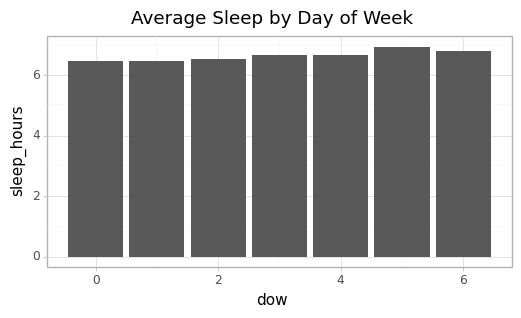

<ggplot: (114504902248)>

In [23]:
(
    ggplot(data=(train
                 .filter(['dow', 'sleep_hours'])
                 .groupby('dow')['sleep_hours']
                 .mean()
                 .reset_index()
                 ),
           mapping=aes(x='dow', y='sleep_hours')) +
    geom_col() +
    labs(title='Average Sleep by Day of Week') +
    theme_light() +
    theme(figure_size=[6,3])
)


In [24]:
(train
 
 )

,date,sleep_hours,active_energy,exercise_minutes,HKCategoryValueAppleStandHourIdle,HKCategoryValueAppleStandHourStood,HKCategoryValueEnvironmentalAudioExposureEventMomentaryLimit,minutes_stood,basal_energy,body_mass,body_mass_index,distance_walking_running,env_audio_exposure_min,env_audio_exposure_mean,env_audio_exposure_median,env_audio_exposure_max,flights_climbed,headphone_audio_exposure_min,headphone_audio_exposure_mean,headphone_audio_exposure_median,headphone_audio_exposure_max,heartrate_min,heartrate_mean,heartrate_median,heartrate_max,heartrate_var_min,heartrate_var_mean,heartrate_var_median,heartrate_var_max,oxygen_saturation_min,oxygen_saturation_mean,oxygen_saturation_median,oxygen_saturation_max,respiratory_rate_min,respiratory_rate_mean,respiratory_rate_median,respiratory_rate_max,resting_heartrate,stair_ascent_speed_min,stair_ascent_speed_mean,stair_ascent_speed_median,stair_ascent_speed_max,stair_descent_speed_min,stair_descent_speed_mean,stair_descent_speed_median,stair_descent_speed_max,step_count,vo2_max,walking_asymmetry_min,walking_asymmetry_mean,walking_asymmetry_median,walking_asymmetry_max,walking_support_min,walking_support_mean,walking_support_median,walking_support_max,walking_heartrate_mean,walking_speed_min,walking_speed_mean,walking_speed_median,walking_speed_max,walking_steplength_min,walking_steplength_mean,walking_steplength_median,walking_steplength_max,year,month,dom,doy,week,dow,quarter,holiday,is_holiday,target_lag_1,target_lag_2,target_lag_3,target_lag_4,target_lag_5,target_lag_6,target_lag_7
0,2015-02-19,6.400000,487.000,NaN,NaN,NaN,NaN,NaN,1898.000,188.799,23.5981,1.311870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015,2,19,50,8,3,1,No Holiday,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-02-20,7.583333,1789.000,NaN,NaN,NaN,NaN,NaN,1898.000,188.799,23.5981,7.167910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015,2,20,51,8,4,1,No Holiday,0,6.400000,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-02-21,6.350000,1185.000,NaN,NaN,NaN,NaN,NaN,1898.000,188.799,23.5981,3.823910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015,2,21,52,8,5,1,No Holiday,0,7.583333,6.400000,NaN,NaN,NaN,NaN,NaN
3,2015-02-22,6.500000,2173.000,NaN,NaN,NaN,NaN,NaN,1898.000,188.799,23.5981,8.195990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015,2,22,53,8,6,1,No Holiday,0,6.350000,7.583333,6.400000,NaN,NaN,NaN,NaN
4,2015-02-23,8.916667,903.000,NaN,NaN,NaN,NaN,NaN,1898.000,188.799,23.5981,2.986480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015,2,23,54,9,0,1,No Holiday,0,6.500000,6.350000,7.583333,6.400000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2349,2021-12-25,7.933333,1879.323,103.0,6.0,21.0,NaN,129.0,2140.902,NaN,NaN,16.476420,47.1365,66.784326,69.42710,90.7920,65.0,16.9828,63.692937,72.73825,81.1134,51.7172,75.829723,66.0,166.923,29.5793,52.024563,53.30005,85.0860,0.95,0.968750,0.96,1.00,15.5,17.144737,17.00,19.0,